# 5. Gaussian Process

In Bayesian regression, we assumed linear relationship between the output and the inputs or the tranformation of inputs. 
- Given training data set $\mathcal{D} = \{(X_n, T_n)\}_{n=1}^N$, we want to predict the output target $t$ for a new input $\mathcal{x}$.
    - Inference: get the posterior distribution $p(w|X, T)$
    - Decision: get the posterior predictive distribution $p(t|x, X, T)$ for a new input $\mathcal{x}$

**Inference**:
- assume a linear model $t = y(x, w) = w^Tx + \epsilon$, where $\epsilon$ is the modeling noise, $y$ is the model to be learned.
- assume a prior distribution for parameters $w$, e.g., $p(w) = N(w|0, I)$
- assume a likelihood function $p(T|X, w)$, e.g., $p(T|X, w) = N(T|y(X), \beta^{-1}I) = N(T|Xw, \beta^{-1}I)$, where $\beta$ is the precision of the modeling noise. The unknown parameters are $w$ and $\beta$, which can be solved by maximizing the logrithatic likelihood function $p(T|X, w)$.
    - $p(T|X, w) = \prod_{n=1}^N N(T_n|X_nw, \beta^{-1})$
    - $\log p(T|X, w) = -\frac{\beta}{2}\sum_{n=1}^N (T_n - X_nw)^2 + \frac{N}{2}\log \beta - \frac{N}{2}\log (2\pi)$
    - by solving the optimization problem, we can get the $w$ and $\beta$ that maximize the likelihood 
- assume a posterior distribution $p(w|X, T)$, which is propotional ot the product of the prior distribution and the likelihood. Due to the choice of a conjugate Gaussian prior distribution, the posterior distribution is alos a Gaussian distribution. Let's assume $p(w|X, T) = N(w|m_N, S_N)$ after observing $N$ data from training set. The mean $m_N$ and variance $S_N$ can be calculated based on marginal and conditional Gaussian principles as follows:
    - $p(w|X, T) = N(w|m_N, S_N)$
    - $S_N^{-1} = \beta XX^T + I$
    - $m_N = \beta S_N X^T T$

**Decision**
- based on conditional and marginal probability rules, the posterior predictive distribution $p(t|x,X,T)$ can be expressed as:
    - $p(t|x,X,T) = \int p(t|x,w)p(w|X,T)dw$
    - $p(t|x,X,T) = N(t|m_N^Tx, \sigma_N^2(x))$
    - $\sigma_N^2(x) = \beta^{-1} + x^TS_Nx$


Gaussian process is very similar to the above process, but there are also differences:
- GP instead of inferencing the parameters of a given linear model $y(x) = w^Tx$, infers the function itself $y(x)$ directly from the training data.
- GP is a non-parametric approach, which means that the number of parameters grows with the size of the training data set.
- GP is a distribution over functions, which is defined by a mean function $m(x)$ and a covariance function $k(x, x')$.
- GP is a memory-based approach, like k-NN, which means it stores the training data and uses all of them to predict the output for a new input. It will require retraining the model when new data is added to the training set.

## 5.1 Gaussian Process Regression

The regression problem is standard:
- given training set $(X, T)$, predict the output $t$ for a new input $x$.

**Inference**
- assume the prediction is made by a Gaussian process $y(x)$ so that $t_i = y(x_i) + \epsilon_i$ for all the data points in the training set, where $\epsilon_i$ is the modeling noise.
- get conditional distribution $p(T|y(X)) = N(T|y(X), \beta^{-1}I_N)$
- assume the Gaussian process prior or marginal distribution $p(y(X)) = N(y(X)|m(X), k(X, X'))$, where $m(X)$ is the mean function and $k(X, X')$ is the covariance function, also known as kernel function.
    - we can always assume 0 mean for prior distribution, i.e., $p(y) = N(y|0, K)$, where $K$ is $k(X, X')$
- find the conditional distribution $p(T|X)$:
    - $p(T|X) = \int_{y} p(T, y|X)dy = \int_{y} p(T|y,X)p(y|X)dy$
    - $p(T|X) = N(T|0, C_N)$
    - $C_N = K_N + \beta^{-1}I_N$ -> simply add the covariance due to independency

**Decision**
- find the posterior distribution $p(t|x, X, T)$:
    - get joint distribution $p(t, T|x, X)$ based on conditional distribution $p(T|X)$ -> simply added one more data point
        - $p(t, T|x, X) = N(t,T|0, C_{N+1})$
        - $ C_{N+1} = \begin{bmatrix}
                        C_N & \mathcal{k} \\
                        \mathcal{k}^T & c
                        \end{bmatrix} 
          $ -> (N+1)-by-(N+1) matrix
        - $c = k(x, x') + \beta^{-1}, \mathcal{k} = k(x_N, x_{N+1}) = k(X[-1], x)$
    - get conditional distribution $p(t|x, X, T)$ based on joint distribution $p(t, T|x, X)$
        - $p(t|x, X, T) = N(t|m(x), \sigma^2(x))$
        - $m(x) = \mathcal{k}^TC_N^{-1}T$
        - $\sigma^2(x) = c - \mathcal{k}^TC_N^{-1}\mathcal{k}$

In [1]:
import jax
import jax.scipy as jsp
import jax.numpy as jnp 
import numpy as np
np.random.seed(0)

from basic.kernel.kernel import Polynomial, RadialBasisFunction
from basic.kernel.gaussian_process_regression import GaussianProcessRegression

def create_toy_data(func, n=10, std=1., domain=[0., 1.]):
    x = np.linspace(domain[0], domain[1], n)
    t = func(x) + np.random.normal(scale=std, size=n)
    return x, t

def sinusoidal(x):
        return jnp.sin(2 * jnp.pi * x)

In [2]:
import matplotlib.pyplot as plt

# Generate some example data
X_train, y_train = create_toy_data(sinusoidal, n=7, std=0.1, domain=[0., 0.7])
X_test = np.linspace(0, 1, 100)

# Define the kernel parameters
rbf = RadialBasisFunction()
params = {'variance': 1.0, 'length_scale': 15.0}
# test kernel
rbf.kernel(params, X_train, X_train)

# define a polynominial kernel
poly = Polynomial()
params_poly = {'degree': 2, 'constant': 0.5}
poly.kernel(params_poly, X_train, X_train)


2023-05-11 23:06:37.234691: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array([[0.25      , 0.25      , 0.25      , 0.25      , 0.25      ,
        0.25      , 0.25      ],
       [0.25      , 0.2637964 , 0.27796325, 0.2925007 , 0.30740863,
        0.32268712, 0.33833608],
       [0.25      , 0.27796325, 0.30740863, 0.33833608, 0.37074566,
        0.4046374 , 0.44001105],
       [0.25      , 0.2925007 , 0.33833608, 0.38750625, 0.44001105,
        0.49585068, 0.555025  ],
       [0.25      , 0.30740863, 0.37074566, 0.44001105, 0.51520497,
        0.5963272 , 0.68337774],
       [0.25      , 0.32268712, 0.4046374 , 0.49585068, 0.5963272 ,
        0.7060668 , 0.82506937],
       [0.25      , 0.33833608, 0.44001105, 0.555025  , 0.68337774,
        0.82506937, 0.98010004]], dtype=float32)

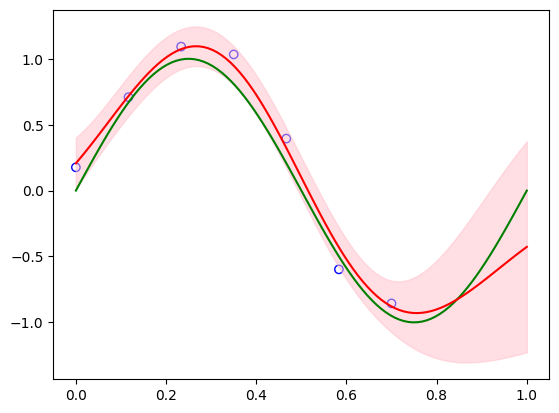

In [3]:
# Define the kernel parameters
params = {'variance': 1.0, 'length_scale': 15.0}

# Define the noise variance
noise_variance = 0.05

gpr = GaussianProcessRegression()
mu_s, cov_s = gpr.predict(rbf, params, X_train, y_train, X_test, noise_variance)

plt.scatter(X_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(X_test, sinusoidal(X_test), color="g", label="sin$(2\pi x)$")
plt.plot(X_test, mu_s.reshape(-1), color="r", label="gpr")
plt.fill_between(X_test, mu_s.reshape(-1) - jnp.sqrt(jnp.diag(cov_s)), mu_s.reshape(-1) + jnp.sqrt(jnp.diag(cov_s)), alpha=0.5, color="pink", label="std")
plt.show()